This is an example for comparison of co-locationship network and social relationship network

# Import packages

In [1]:
import numpy as np
import pandas as pd
import colocationship as cl

%load_ext autoreload
%autoreload 2

# Co-Locationship Network Experiment

## Dataset Information Check

We first discard all incomplete records (any missing attributes in userid, datetime, placeid) and we require that each valid user should have at least 150 check-ins.

In [2]:
df_checkin = pd.read_csv("../dataset/weeplace_checkins.csv")
co_locationship = cl.Co_Locationship(df_checkin, mins_records=150, missing='-')

In [3]:
print('There are', co_locationship.pdata['userid'].count(), 'valid check-ins records, \n'
      'There are', co_locationship.pdata['userid'].nunique(), 'valid users, \n'
      'There are', co_locationship.pdata['placeid'].nunique(), 'distinct placeid. \n'
     )

There are 7049037 valid check-ins records, 
There are 11533 valid users, 
There are 924666 distinct placeid. 



## Generate all temporal placeid sequences

"placeidT" means all temporal placeid sequences for all valid users, which can be also used in social relationship network directly.
It may takes long time (approximate 45 mins), so we can save it when we obtain it.

In [4]:
# # First time, should run co_locationship
# placeidT = co_locationship()

placeidT = cl.util.read_object("../interim/weeplace_placeidT_150.pickle")
co_locationship.placeidT = placeidT

Since temporal placeid sequence is expensive computation cost, we can save it as interim.

In [7]:
# cl.util.save_object(placeidT, 'interim/weeplace_placeidT_150.pickle')

## Build Co-Locationship Network

Since building network is expensive computation cost (about 7 hours), we can save it as interim.

In [5]:
# # Run in the first time (it takes 40 mins)
# cln = co_locationship.build_network(freq='H')
# cln.to_csv('interim/weeplace_raw_meetup.csv', index=False)

co_locationship.network = pd.read_csv('../interim/weeplace_raw_meetup.csv')

In [6]:
print(co_locationship.network['userid_x'].nunique(), co_locationship.network['userid_y'].nunique())

11078 11078


## Calculate Co-Locationship network information

In [7]:
# # Run in the first time (it takes 18 hours)
# cln_details = co_locationship.calculate_info()
# # cln_details.to_csv('interim/weeplace_CLN_CE_info.csv', index=False)

# The second time, you can just read the saved result
co_locationship.network_details = pd.read_csv('../interim/weeplace_CLN_CE_info.csv')

In [8]:
print(co_locationship.network_details['userid_x'].nunique(), 
      co_locationship.network_details['userid_y'].nunique())

11078 11078


In [9]:
cln_filtered = co_locationship.network_control(quality=True, 
                                contribution=True, 
                                num_alters=10, 
                                by=['userid_x', 'meetup', 'N_previous'], 
                                ascending=[True, False, True],
                                N_previous=150)

In [10]:
print(cln_filtered['userid_x'].nunique(), cln_filtered['userid_y'].nunique())

751 3876


## Calculate Co-Locationship network details (cumulative info)

In [11]:
# # Run in the first time (it takes 1 hour)
# co_locationship.calculate_network(verbose=False, filesave=True)

# The second time, you can just read the saved result
co_locationship.network_details = pd.read_csv('../result/weeplace/CLN_network_details_H.csv')
co_locationship.final_userlist = sorted(list(set(co_locationship.network_details['userid_x'].tolist())))

# Social-Relationship Network Experiment

In [12]:
df_friend = pd.read_csv("../dataset/weeplace_friends.csv")
social_relationship = cl.Social_Relationship(df_checkin,df_friend, 
                                             mins_records=150, 
                                             missing='-')

In [13]:
srn = social_relationship.network
print('There are', srn['userid_x'].nunique(), 'valid egos \n' 
     'There are', srn['userid_y'].nunique(), 'valid alters \n' 
     'There are', len(set(srn['userid_x'].tolist() + srn['userid_y'].tolist())), 'total users \n' 
     )

There are 10999 valid egos 
There are 10998 valid alters 
There are 10999 total users 



In [14]:
# given the same time unit, we can just the placeid sequence generated by co-locationship
# otherwise, also run `social_relationship()` to generate placeid sequence again.
social_relationship.placeidT = placeidT

In [15]:
# # Run in the first time (it takes 2.5 hours)
# srn_details = social_relationship.calculate_info()
# srn_details.to_csv('interim/weeplace_SRN_CE_info.csv', index=False)

# The second time, you can just read the saved result
social_relationship.network_details = pd.read_csv('../interim/weeplace_SRN_CE_info.csv')

In [16]:
srn_filtered = social_relationship.network_control(
                                contribution=True, 
                                num_alters=10, 
                                by=['userid_x', 'meetup', 'N_previous'], 
                                ascending=[True, False, True],
                                N_previous=150,
                                freq='H')

In [17]:
# # Run in the first time (it takes 2.5 hour)
# social_relationship.calculate_network(verbose=False, filesave=True)

# The second time, you can just read the saved result
social_relationship.network_details = pd.read_csv('../result/weeplace/SRN_network_details_H.csv')
social_relationship.final_userlist = sorted(list(set(social_relationship.network_details['userid_x'].tolist())))

# Comparison

In [18]:
compare_v2 = cl.ComparisonNetwork([co_locationship, social_relationship], 
                                  ['co-locationship', 'social relationship'])

In [19]:
compare_v2()

There are 285 common users.


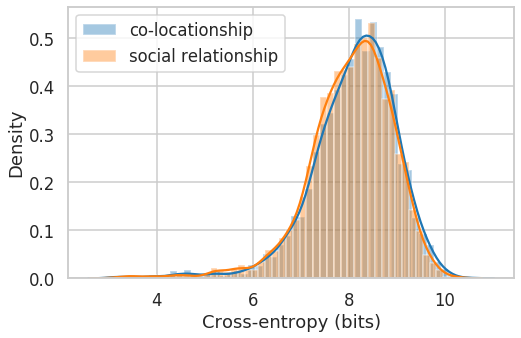

In [20]:
CE_v2 = compare_v2.plot_CE(l=8,w=5)

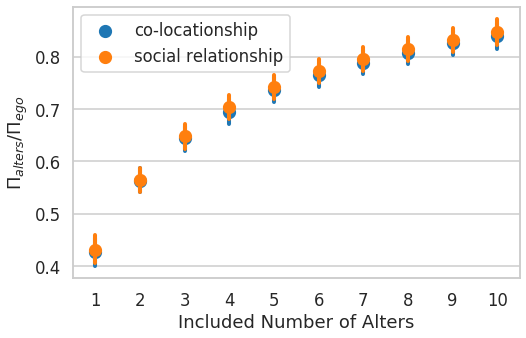

In [24]:
RCCP_alters_errorbar_v2 = compare_v2.plot_errorbar(target='alters', l=8,w=5)

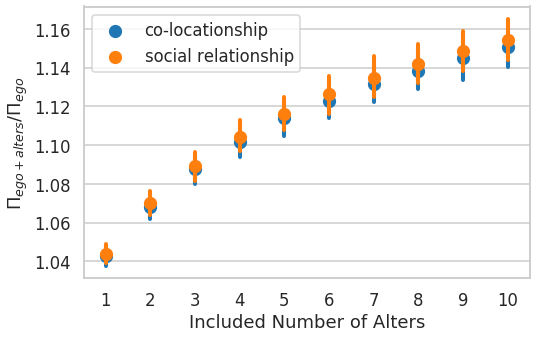

In [25]:
RCCP_ego_alters_errorbar_v2 = compare_v2.plot_errorbar(target='ego+alters', l=8,w=5)

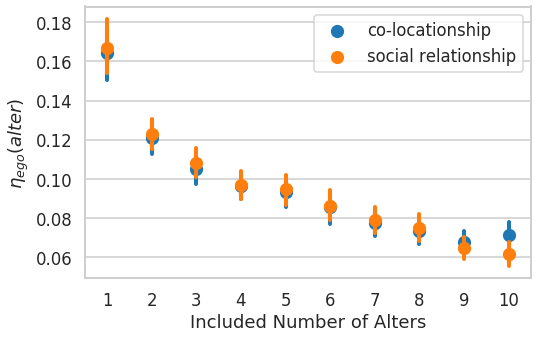

In [26]:
ODLR_errorbar_v2 = compare_v2.plot_errorbar(target='ODLR', l=8,w=5)

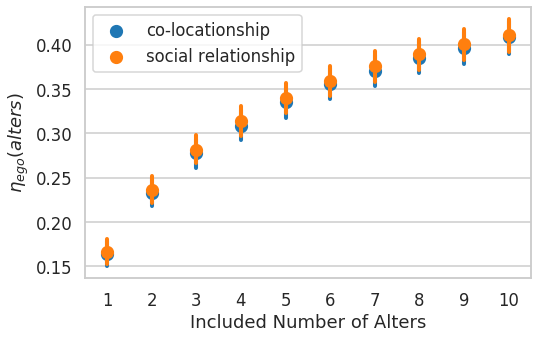

In [27]:
CODLR_errorbar_v2 = compare_v2.plot_errorbar(target='CODLR', l=8,w=5)

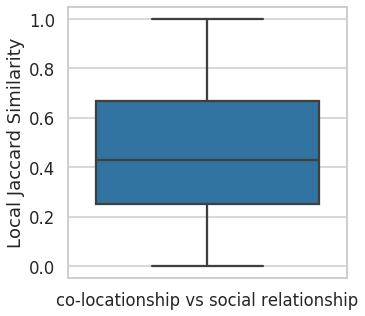

In [28]:
local_sim_v2 = compare_v2.plot_similarity(local=True, l=5,w=5)

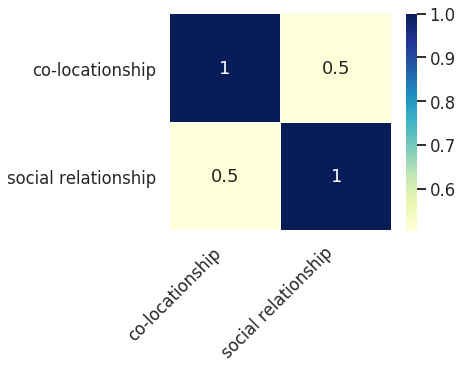

In [29]:
global_sim_v2 = compare_v2.plot_similarity(local=False, l=5,w=4)

In [29]:
compare_v2.stats_test_monotonicity(target='alters')

,dataset,category,SpN,SpP,Kn,Kp,total
0,dataset,co-locationship,269,0.943860,272,0.954386,285
1,dataset,social relationship,273,0.957895,282,0.989474,285


In [30]:
compare_v2.stats_test_monotonicity(target='ego+alters')

,dataset,category,SpN,SpP,Kn,Kp,total
0,dataset,co-locationship,278,0.975439,280,0.982456,285
1,dataset,social relationship,282,0.989474,284,0.996491,285


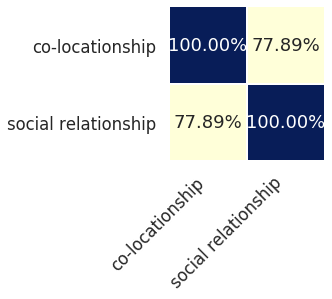

In [31]:
consistency_test = compare_v2.stats_test_consistency(target='alters')

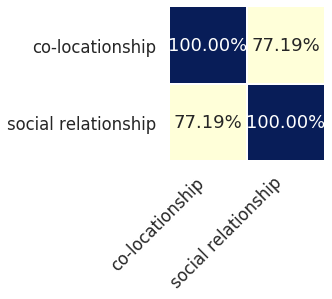

In [32]:
consistency_test = compare_v2.stats_test_consistency(target='ego+alters')